In [1]:
#Description : This program uses an artifical RNN called Long Short Term Memory (LSTM)
              # to predict the closing stock price of a corporation (Apple Inc.) using the pase 60 days stock price

In [2]:
#run only once :
!pip install --upgrade pandas_datareader

     |████████████████████████████████| 109 kB 31.2 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [53]:
#import the lib
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [118]:
#Get the stock quote
df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2021-11-01')
#Show the data
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.591939
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.659606
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.800156
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.933969
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.913451
...,...,...,...,...,...,...
2021-10-26,150.839996,149.009995,149.330002,149.320007,60893400.0,149.102402
2021-10-27,149.729996,148.490005,149.360001,148.850006,56094900.0,148.633087
2021-10-28,153.169998,149.720001,149.820007,152.570007,100077900.0,152.347656


In [119]:
#Get the number of rows and columns in the data set
df.shape

(2475, 6)

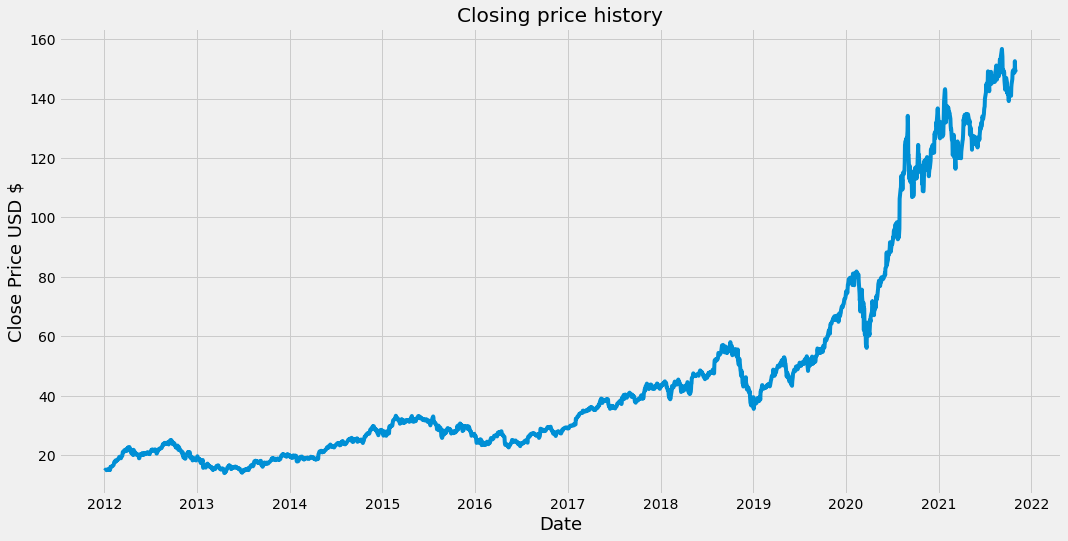

In [120]:
#Visualize the closing price
plt.figure(figsize=(16, 8))
plt.title("Closing price history")
plt.plot(df['Close'])
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price USD $", fontsize = 18)
plt.show()

In [121]:
#Create a new df with only the close column
data = df.filter(['Close'])
#convert the dataframe to a numpy array
dataset = data.values
#get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * .8)

training_data_len

1980

In [122]:
#Scale the data -> almost super advantageous to apply preprocessing normalization before presenting it to a RNN
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00517915],
       [0.00573209],
       [0.00688052],
       ...,
       [0.97113687],
       [0.95173127],
       [0.94584657]])

In [123]:
#Create the training dataset
#Create the scaled training dataset
train_data = scaled_data[0:training_data_len, :]
#Split the data into x_train and y_train -> x_train are the independant training variables, y_train are the dependant variables (target var)
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
  if i<= 60:
    print(x_train)
    print(y_train)
    print()
    



[array([0.00517915, 0.00573209, 0.00688052, 0.0079739 , 0.00780626,
       0.00818406, 0.00801143, 0.00772119, 0.00732587, 0.00854936,
       0.00965275, 0.00931247, 0.00744847, 0.0092274 , 0.007476  ,
       0.01404377, 0.01353586, 0.0141989 , 0.01563254, 0.01650074,
       0.01642818, 0.01616047, 0.01730138, 0.01837474, 0.01959072,
       0.0215548 , 0.02568061, 0.02574316, 0.02804001, 0.02975638,
       0.02680652, 0.02794242, 0.02791991, 0.03110496, 0.03065209,
       0.03149026, 0.03299647, 0.03383465, 0.03624909, 0.03800799,
       0.0385159 , 0.03869355, 0.03568614, 0.03496055, 0.03506814,
       0.03789542, 0.03869105, 0.04039993, 0.04442815, 0.04980247,
       0.04879666, 0.04879916, 0.05268478, 0.05390076, 0.05303505,
       0.05224443, 0.05142127, 0.05415595, 0.05603247, 0.0568181 ])]
[0.05487653421186173]



In [124]:
#Convert the y_train and x_train to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

In [125]:
#Reshape the data -> in order to have an input (samples, timestamps, feature) for the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1920, 60, 1)

In [126]:
#Build the LSTM model
model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(LSTM(60, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(30))
model.add(Dense(15))
model.add(Dense(1))

#tips to reduce overfitting -> optimizer = ranger, not ReLu activation but MISH, add fully connnected layers Dense

In [127]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [135]:
model.fit(x_train, y_train, batch_size=1, epochs=1)
model.save('LSTM_MODEL.h5')

1920/1920 [==============================] - 56s 29ms/step - loss: 2.6641e-04


In [136]:

1#Create the testing dataset
#Create a new array containing scaled values from index 1752 to 2265 
test_data = scaled_data[training_data_len - 60 : , :]
#Create the datasets x_test and y_test
x_test = [] #values that we want our model to predict
y_test = dataset[training_data_len:, :] # actual values not scaled

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])
  

In [137]:
#Convert the data into numpy array
x_test = np.array(x_test)

In [138]:
#Reshape the data to have it 3 dimensionnal for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [139]:
#Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) # -> unscaling the values to get the actual stock prices


In [140]:
#Get the root mean squared error (RMSE) good measure of how good the model predicted the values
# The lows values of RMSE shows that the model is well fit
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

3.6563427549419982

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


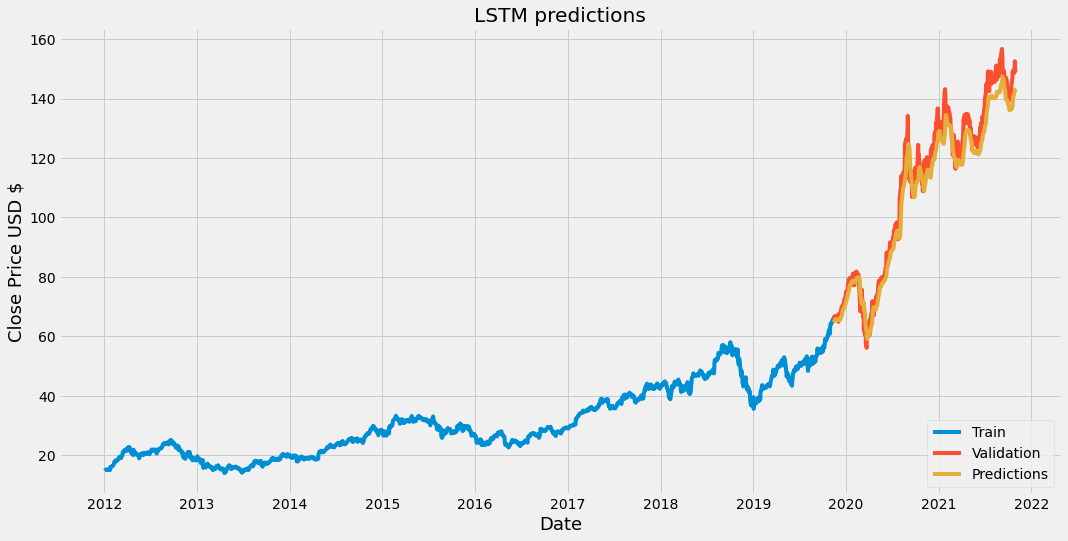

In [141]:
#That looks pretty fucking good man
# The model matches almost perfectly the values, it might be naive but we'll see

#Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16, 8))
plt.title('LSTM predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD $', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Validation', 'Predictions'], loc='lower right')
plt.show()

In [142]:
#Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2019-11-14,65.660004,64.747421
2019-11-15,66.440002,64.959419
2019-11-18,66.775002,65.194199
2019-11-19,66.572502,65.453514
2019-11-20,65.797501,65.662315
...,...,...
2021-10-26,149.320007,141.973251
2021-10-27,148.850006,142.341431
2021-10-28,152.570007,142.543442


In [143]:
#Get the quote
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2021-11-10')
#Create a new dataframe
new_df = apple_quote.filter(['Close'])
#get the last 60 day closing price values and convert the df to an array
last_60_days = new_df[-60:].values
#Scale the data to be between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
#Append the past 60 days to the X_test list
X_test.append(last_60_days_scaled)
#COnvert the X_test to a numpy array
X_test = np.array(X_test)
#Reshape the data to 3 dim -> for the LSTM model
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[143.76955]]


In [145]:
#Get the quote
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start='2021-11-10', end='2021-11-10')
print(apple_quote2['Close'])

Date
2021-11-10    147.919998
Name: Close, dtype: float64


In [ ]:
#So we can see that the price differs of only around 3 USD $. Which is pretty fucking good